# Flights Delay Insights

## Table of contents<a class="anchor" id="table"></a>

* [1. Data Loading, Cleaning, Labelling, and Exploration](#1)                                       
 * [1.1. Data loading](#1.1)                                              
    * [1.1.1.Create SparkSession and SparkContext](#1.1.1)                                              
    * [1.1.2 Import CSV file to a Spark SQL table](#1.1.2)                                              
    * [1.1.3 Obtain the list of columns from flightsRawDf](#1.1.3)  
 * [1.2 Data cleaning](#1.2)   
    * [1.2.1 Check for missing values](#1.2.1)
    * [1.2.2 Remove columns and rows](#1.2.2)
 * [1.3 Data Labelling](#1.3) 
    * [1.3.1 Generate Binary labels](#1.3.1)
    * [1.3.2 Generate Multiclass labels](#1.3.2)
    * [1.3.3 Generate Automatic Multiclass labels](#1.3.3)
 * [1.4 Data Exploration / Exploratory Analysis](#1.4)
    * [1.4.1 Basic statistics](#1.4.1)
    * [1.4.2 Histograms for fligths delay](#1.4.2)
* [2. Feature extraction and ML Training](#2)
 * [2.1 Feature selection](#2.1)
 * [2.2 Preparing Spark ML Transformers/ Estimators](#2.2)
    * [2.2.1 Transform the dataset](#2.2.1)
    * [2.2.2 Model Estimators](#2.2.2)
 * [2.3 Split dataset](#2.3)
 * [2.4 Training and evaluating models](#2.4)
    * [2.4.1 Binary Classification](#2.4.1)
    * [2.4.2 Multiclass Classification](#2.4.2)
    
    
    
    

## 1. Data Loading, Cleaning, Labelling, and Exploration <a class="anchor" id="1"></a>

### 1.1 Data loading <a class="anchor" id="1.1"></a>
[Back to top](#table)

#### 1.1.1 Create SparkSession and SparkContext<a class="anchor" id="1.1.1"></a>

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment 2 - Ricardo Arias (ID: 30550971)"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

#### 1.1.2 Import CSV file to a Spark SQL table <a class="anchor" id="1.1.2"></a>                                              
To upload the data as dataframe, we will use a function that allow the user to input the path of the CSV files, and convert them into a data frame with header and a schema infered

In [2]:
def csv_to_DF(path): # Path of the file, list with the name of the columns that are int and float
     # Read the CSV file and convert it into a data frame with header, besides it has to infer the Schema
    df = spark.read.format("csv").options(header='true',inferSchema='true').load(path)
    return(df)

Now that the function is created we proceed to import the data

In [3]:
flightsRawDf = csv_to_DF('./flight-delays/flight*.csv')

# Print number of partitions, rows and columns
print("The dataframe flightsRawDf has", flightsRawDf.count(),'rows and', len(flightsRawDf.columns), "columns")

The dataframe flightsRawDf has 582184 rows and 31 columns


#### 1.1.3 Obtain the list of columns from flightsRawDf <a class="anchor" id="1.1.3"></a>                                   
With the function columns we can get a list with the name of each column of the dataset

In [4]:
allColumnFlights = flightsRawDf.columns

### 1.2 Data cleaning <a class="anchor" id="1.2"></a>
[Back to top](#table)

#### 1.2.1 Check for missing values <a class="anchor" id="1.2.1"></a>                                                       
With the following function we will calculate the number of missing values per column in this dataframe

In [5]:
flightsRawDf.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in flightsRawDf.columns]).collect()

[Row(YEAR=0, MONTH=0, DAY=0, DAY_OF_WEEK=0, AIRLINE=0, FLIGHT_NUMBER=0, TAIL_NUMBER=1462, ORIGIN_AIRPORT=0, DESTINATION_AIRPORT=0, SCHEDULED_DEPARTURE=0, DEPARTURE_TIME=8633, DEPARTURE_DELAY=8633, TAXI_OUT=8891, WHEELS_OFF=8891, SCHEDULED_TIME=1, ELAPSED_TIME=10455, AIR_TIME=10455, DISTANCE=0, WHEELS_ON=9257, TAXI_IN=9257, SCHEDULED_ARRIVAL=0, ARRIVAL_TIME=9257, ARRIVAL_DELAY=10455, DIVERTED=0, CANCELLED=0, CANCELLATION_REASON=573213, AIR_SYSTEM_DELAY=475831, SECURITY_DELAY=475831, AIRLINE_DELAY=475831, LATE_AIRCRAFT_DELAY=475831, WEATHER_DELAY=475831)]

Now if we use the number of rows of the dataframe we can calculate the proportion of missing values in each column. As it can be seen

In [6]:
numOfRows = flightsRawDf.count()

flightsRawDf.select([round(count(when(isnan(x) | col(x).isNull(), x))/numOfRows, 3).alias(x)\
                     for x in flightsRawDf.columns]).collect()

[Row(YEAR=0.0, MONTH=0.0, DAY=0.0, DAY_OF_WEEK=0.0, AIRLINE=0.0, FLIGHT_NUMBER=0.0, TAIL_NUMBER=0.003, ORIGIN_AIRPORT=0.0, DESTINATION_AIRPORT=0.0, SCHEDULED_DEPARTURE=0.0, DEPARTURE_TIME=0.015, DEPARTURE_DELAY=0.015, TAXI_OUT=0.015, WHEELS_OFF=0.015, SCHEDULED_TIME=0.0, ELAPSED_TIME=0.018, AIR_TIME=0.018, DISTANCE=0.0, WHEELS_ON=0.016, TAXI_IN=0.016, SCHEDULED_ARRIVAL=0.0, ARRIVAL_TIME=0.016, ARRIVAL_DELAY=0.018, DIVERTED=0.0, CANCELLED=0.0, CANCELLATION_REASON=0.985, AIR_SYSTEM_DELAY=0.817, SECURITY_DELAY=0.817, AIRLINE_DELAY=0.817, LATE_AIRCRAFT_DELAY=0.817, WEATHER_DELAY=0.817)]

Looking at the percentages we have 26 under 2% of missing values and some other over 80%, so if we set any threshold between 2% and 80% we will get the same set of columns, even though we will select 50% as threshold considering that is a columns has more missing values than values it is not worth it to analyse

#### 1.2.2 Remove columns and rows in the flightsRawDf <a class="anchor" id="1.2.2"></a>   

#### Get columns over the threshold of missing values                 
The following function automatically obtains the column names for all columns in flightsRawDf whose number of missing values is greater certain percent. To do that, we first calculate the percetage of missing values in each column of the dataset given, then we convert that dataframe into a dictionary, and we only get the keys that are above the threshold value

In [5]:
def find_removed_columns(threshold, df):
    
    # Dictionary that stores the percentage of missing values in eac
    dict_perc = flightsRawDf.select([(count(when(isnan(x) | col(x).isNull(), x))/numOfRows).alias(x)\
                     for x in flightsRawDf.columns]).collect()[0].asDict()
    # Getting the keys of the dictionary which the values meet the criteria of selection
    removedColumns = [x for x in dict_perc if dict_perc[x] > threshold]
    
    return removedColumns

As we already mentioned above, the threshold selected in this case is 0.5 (50%)

In [6]:
threshold = 0.5 # Threshold value which defines percentage

find_removed_columns(threshold, flightsRawDf)

['CANCELLATION_REASON',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']

And we get those columns that have more than 50% of their values as missing values

#### Remove columns over the threshold of missing values   
Once a list variable removedColumns is obtained, we created another function `eliminate_columns` so that flightsRawDf is updated by removing columns listed in removedColumns variable. 

In [7]:
def eliminate_columns(columns, df):
    # Drop the columns inputed
    df = df.drop(*columns)
    return df

Using both functions, the one that identifies the columns with a percentage of missing values above the threshold and the one that removes those columns from the original dataframe we will create a new dataframe called `flightsDf` that only stores the columns that we are interested in

In [8]:
# Get the columns that have a percentage of missing values above of the threshold
removedColumns = find_removed_columns(threshold, flightsRawDf)

# Remove those columns from the dataframe
flightsDf = eliminate_columns(removedColumns, flightsRawDf)

In [11]:
# Print number of partitions, rows and columns
print("The dataframe flightsDf has", flightsDf.count(),'rows and', len(flightsDf.columns), "columns")

The dataframe flightsDf has 582184 rows and 25 columns


In this case we can observe that `flightsDf` and `flightsRawDf` have the same number of rows, but `flightsDf` has 6 columns less than `flightsRawDf`, that are the ones that we showed above

### 1.3 Data Labelling <a class="anchor" id="1.3"></a>
[Back to top](#table)

#### 1.3.1 Generate Binary labels <a class="anchor" id="1.3.1"></a>
Using flightsDf we create new binary labels are `binaryArrDelay` and `binaryDeptDelay`, which are generated from `ARRIVAL_DELAY` and `DEPARTURE_DELAY` respectively. The data is labeled as follows: 
   - **Delay value greater than 0 (Late):** 1
   - **Delay value lower than 0 (Not late):** 0

In [9]:
flightsDf = flightsDf.withColumn('binaryArrDelay', f.when(flightsDf.ARRIVAL_DELAY > 0, 1).otherwise(0))\
                     .withColumn('binaryDeptDelay', f.when(flightsDf.DEPARTURE_DELAY > 0, 1).otherwise(0))

Now we can see the two new columns that were created

In [13]:
flightsDf.take(1)

[Row(YEAR=2015, MONTH=6, DAY=26, DAY_OF_WEEK=5, AIRLINE='EV', FLIGHT_NUMBER=4951, TAIL_NUMBER='N707EV', ORIGIN_AIRPORT='BHM', DESTINATION_AIRPORT='LGA', SCHEDULED_DEPARTURE=630, DEPARTURE_TIME=629, DEPARTURE_DELAY=-1, TAXI_OUT=13, WHEELS_OFF=642, SCHEDULED_TIME=155, ELAPSED_TIME=141, AIR_TIME=113, DISTANCE=866, WHEELS_ON=935, TAXI_IN=15, SCHEDULED_ARRIVAL=1005, ARRIVAL_TIME=950, ARRIVAL_DELAY=-15, DIVERTED=0, CANCELLED=0, binaryArrDelay=0, binaryDeptDelay=0)]

In [52]:
import seaborn as sns

[Text(0.5, 1.0, 'Categories binaryArrDelay Label')]

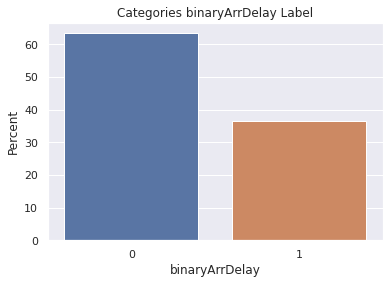

In [53]:
flightsDf_pandas = flightsDf.toPandas()
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="binaryArrDelay", y="binaryArrDelay", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories binaryArrDelay Label")

[Text(0.5, 1.0, 'Categories binaryDeptDelay Label')]

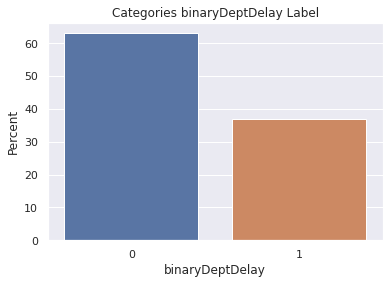

In [54]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="binaryDeptDelay", y="binaryDeptDelay", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories binaryDeptDelay Label")

#### 1.3.2 Generate Multiclass labels <a class="anchor" id="1.3.2"></a>

Using flightsDf we create new multiclass labels `multiClassArrDelay` and `multiCassDeptDelay`, which are generated from `ARRIVAL_DELAY` and `DEPARTURE_DELAY` respectively. The data is labeled as follows:
- **Delay value lower than 5 (Early):** 0
- **Delay value between 5 and 20 (On time):** 1
- **Delay value greater than 20 (Late):** 2

In [10]:
flightsDf = flightsDf.withColumn('multiClassArrDelay', f.when(flightsDf.ARRIVAL_DELAY < 5, 0)\
                                 .otherwise(f.when(flightsDf.ARRIVAL_DELAY <= 20, 1).otherwise(2)))\
                     .withColumn('multiClassDeptDelay', f.when(flightsDf.DEPARTURE_DELAY < 5, 0)\
                                 .otherwise(f.when(flightsDf.DEPARTURE_DELAY <= 20, 1).otherwise(2)))              

Now we can see the two new columns that were created

In [15]:
flightsDf.take(1)

[Row(YEAR=2015, MONTH=6, DAY=26, DAY_OF_WEEK=5, AIRLINE='EV', FLIGHT_NUMBER=4951, TAIL_NUMBER='N707EV', ORIGIN_AIRPORT='BHM', DESTINATION_AIRPORT='LGA', SCHEDULED_DEPARTURE=630, DEPARTURE_TIME=629, DEPARTURE_DELAY=-1, TAXI_OUT=13, WHEELS_OFF=642, SCHEDULED_TIME=155, ELAPSED_TIME=141, AIR_TIME=113, DISTANCE=866, WHEELS_ON=935, TAXI_IN=15, SCHEDULED_ARRIVAL=1005, ARRIVAL_TIME=950, ARRIVAL_DELAY=-15, DIVERTED=0, CANCELLED=0, binaryArrDelay=0, binaryDeptDelay=0, multiClassArrDelay=0, multiClassDeptDelay=0)]

#### 1.3.3 Generate Automatic Multiclass labels<a class="anchor" id="1.3.3"></a>
In this task we wrote a function to execute data labelling automatically, in the last task we labeled them using a hardcoding method. In this function the user may determine the thresholds to determine each category. How many minutes of delay is considered early, and how many minutes is considered late. 

In [11]:
def createMulticlassLabel(df, earlyThreshold, lateThreshold):
    # df: Dataframe to be transformed
    # earlyThreshold: The number of minutes of delay that you consider as early (Lower than this number)
    # lateThreshold: The number of minutes of delay that you consider as late (Greater than this number)
    
    transformed_df = df.withColumn('multiClassArrDelayAuto', f.when(df.ARRIVAL_DELAY < earlyThreshold, 0)\
                                   .otherwise(f.when(df.ARRIVAL_DELAY <= lateThreshold, 1).otherwise(2)))\
                        .withColumn('multiClassDeptDelayAuto', f.when(df.DEPARTURE_DELAY < earlyThreshold, 0)\
                                    .otherwise(f.when(df.DEPARTURE_DELAY <= lateThreshold, 1).otherwise(2))) 
    
    return transformed_df    

In order to effectively select the best thresholds for each category we will test different thresholds and we are going to observe the distribution of each category based on the thresholds selected. Also we are going to identify the distribution of `ARRIVAL_DELAY` and `DEPARTURE_DELAY` measured in minutes

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

flightsDf_pandas = flightsDf.toPandas()

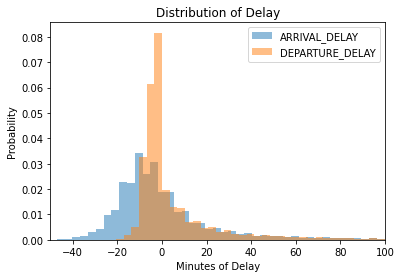

In [20]:
plt.hist(flightsDf_pandas.ARRIVAL_DELAY, density=True, bins=500, label='ARRIVAL_DELAY', alpha=0.5)  
plt.hist(flightsDf_pandas.DEPARTURE_DELAY, density=True, bins=500,label='DEPARTURE_DELAY', alpha=0.5)
plt.ylabel('Probability')
plt.xlabel('Minutes of Delay')
plt.title('Distribution of Delay')
plt.legend(loc='upper right')
plt.xlim([-50, 100]);

By observing this graph we can infere that the flights are more likely to be on time, because the peak of both distributions is around 0, and there are more chances that one flight is late than early. Just taking a look at this graph we can think of three different sets of thresholds that we could select to categorize the flights as `early (0)`, `on time (1)`, and `late (2)`, as we can see in the following table.

|Iteration|Early Threshold|Late Threshold|On-time Threshols|
|:-:|:-:|:-:|:-:|
|1| $\mathcal{x} < \text{0 min}$|$\mathcal{x} >\text{5 min}$|$\text{0} \geq \mathcal{x} \geq \text{5}$|
|2| $\mathcal{x} < \text{-5 min}$|$\mathcal{x} >\text{5 min}$|$\text{-5} \geq \mathcal{x} \geq \text{5}$|
|3| $\mathcal{x} < \text{-10 min}$|$\mathcal{x} >\text{10 min}$|$\text{-10} \geq \mathcal{x} \geq \text{10}$|
   

After having the parameters set, we are going to compare them by using some graphs, that let us know if the label is balanced or not. First we are going to create the first iteration

**Iteration 1**

In [21]:
flightsDf = createMulticlassLabel(flightsDf, 0, 5)

And after doing that we are going to compare the three categories in the two columns created `ARRIVAL` and `DEPARTURE`

[Text(0.5, 1.0, 'Categories multiClassArrDelayAuto Label')]

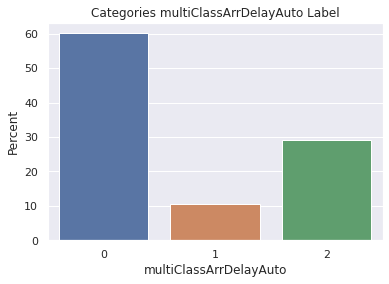

In [23]:
flightsDf_pandas = flightsDf.toPandas()
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="multiClassArrDelayAuto", y="multiClassArrDelayAuto", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories multiClassArrDelayAuto Label")

[Text(0.5, 1.0, 'Categories multiClassDeptDelayAuto Label')]

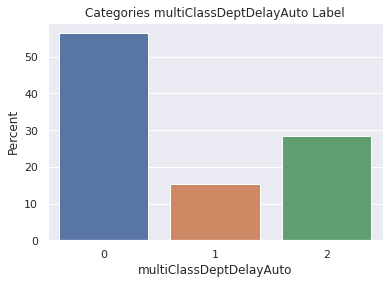

In [24]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="multiClassDeptDelayAuto", y="multiClassDeptDelayAuto", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories multiClassDeptDelayAuto Label")

In this iteration we can observe that the data is pretty unbalanced, as most of the labels are 0, and almost none is 1. This could lead to the model at not predicting well, the categories 1 and 2, because more than 70% of the training sets are labeled as 0. These thresholds are not that good to train the model and that is why we will proceed to do iteration 2

**Iteration 2**

In [25]:
flightsDf = createMulticlassLabel(flightsDf, -5, 5)

Again, after creating the new labels we are going to compare the three categories in the two columns created `ARRIVAL` and `DEPARTURE`

[Text(0.5, 1.0, 'Categories multiClassArrDelayAuto Label')]

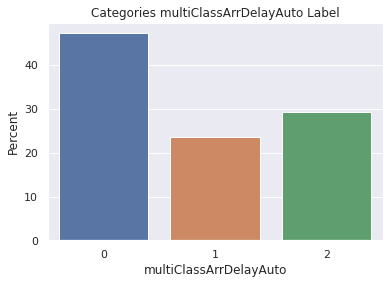

In [26]:
flightsDf_pandas = flightsDf.toPandas()
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="multiClassArrDelayAuto", y="multiClassArrDelayAuto", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories multiClassArrDelayAuto Label")

[Text(0.5, 1.0, 'Categories multiClassDeptDelayAuto Label')]

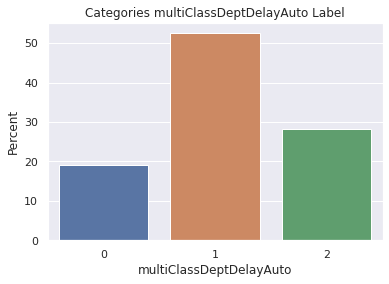

In [27]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="multiClassDeptDelayAuto", y="multiClassDeptDelayAuto", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories multiClassDeptDelayAuto Label")

In this case, we can see that even though the most predominant category changes between `multiClassArrDelayAuto`, and `multiClassDeptDelayAuto`, in both cases the categories are pretty balanced, as each category has more than the 20% of the sets. This is good for training the model

**Iteration 3**

In [28]:
flightsDf = createMulticlassLabel(flightsDf, -10, 10)

Again, after creating the new labels we are going to compare the three categories in the two columns created `ARRIVAL` and `DEPARTURE`

[Text(0.5, 1.0, 'Categories multiClassArrDelayAuto Label')]

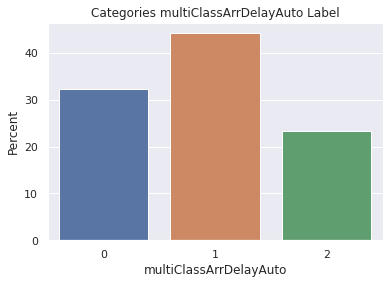

In [29]:
flightsDf_pandas = flightsDf.toPandas()
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="multiClassArrDelayAuto", y="multiClassArrDelayAuto", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories multiClassArrDelayAuto Label")

[Text(0.5, 1.0, 'Categories multiClassDeptDelayAuto Label')]

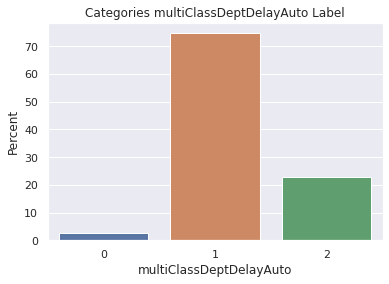

In [30]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="multiClassDeptDelayAuto", y="multiClassDeptDelayAuto", data=flightsDf_pandas,\
                 estimator=lambda x: len(x) / len(flightsDf_pandas) * 100)
ax.set(ylabel="Percent")
ax.set(title="Categories multiClassDeptDelayAuto Label")

In the third iteration we can see that for the column `multiClassArrDelayAuto` the categories are pretty balanced, but not for `multiClassDeptDelayAuto`, and as we mentioned before this could be problematic when training the model for the last column. That is why we decided that the best iteration to train the model is **Iteration 2** and it is the one that we are going to select for training porpuses.

**Threshold Selection**                                                               
*Iteration 2*

In [31]:
flightsDf = flightsDf.drop(*['multiClassArrDelayAuto','multiClassDeptDelayAuto'])

In [12]:
flightsDf = createMulticlassLabel(flightsDf, -5, 5)

Finally, the new columns created that store labels for classifications are

In [13]:
label_cols = ['binaryArrDelay', 'binaryDeptDelay', 'multiClassArrDelay', 'multiClassDeptDelay', 'multiClassArrDelayAuto', 'multiClassDeptDelayAuto']

### 1.4 Data Exploration / Exploratory Analysis <a class="anchor" id="1.4"></a>
[Back to top](#table)

#### 1.4.1 Basic statistics  <a class="anchor" id="1.4.1"></a>
Show the basic statistics for all the columns of the flightsDf, these statistics are:
* count 
* mean 
* stdev
* min
* max
* 25% percentile
* 75% percentile 

To do that first we have to get the numerical columns, because there are columns like `AIRLINE` or `TAIL_NUMBER` that does not have any mean value. Because these columns store string values

In [35]:
# Get only the columns that does not store string values
numeric_columns = [f.name for f in flightsDf.schema.fields if not isinstance(f.dataType, StringType)]

# Return a summary table with all the basic statistics
flightsDf[numeric_columns].summary().toPandas()

,summary,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay,multiClassArrDelay,multiClassDeptDelay,multiClassArrDelayAuto,multiClassDeptDelayAuto
0,count,582184,582184,582184,582184,582184,582184,573551,573551,573293,...,572927,571729,582184,582184,582184,582184,582184,582184,582184,582184
1,mean,2015.0,6.519839088672997,15.708897874211589,3.927804611600456,2169.557499003751,1329.3633541972983,1334.8734550196932,9.39306007661045,16.082287765592813,...,1477.511702188935,4.467084930098001,0.0025490223022274746,0.015409217704368379,0.35908750498124303,0.3645943550492628,0.4718817418548088,0.4590593351929974,0.8192942437442458,1.0910262047737485
2,stddev,0.0,3.4063397236251207,8.777390675387641,1.9867958408825508,1754.691337367653,483.5681282875002,496.1943982309624,37.56953567086646,8.934520575285825,...,525.60037620284,39.78708619085888,0.0504234980416503,0.12317385994704136,0.4797333259834582,0.48131664135028207,0.7612542261443159,0.7559314219390667,0.8558962399743539,0.683103344057408
3,min,2015,1,1,1,1,1,1,-48,1,...,1,-82,0,0,0,0,0,0,0,0
4,25%,2015,4,8,2,730,917,921,-5,11,...,1059,-13,0,0,0,0,0,0,0,1
5,50%,2015,7,16,4,1687,1325,1330,-2,14,...,1512,-5,0,0,0,0,0,0,1,1
6,75%,2015,9,23,6,3221,1730,1740,7,19,...,1917,8,0,0,1,1,1,1,2,2
7,max,2015,12,31,7,7438,2359,2400,1670,200,...,2400,1665,1,1,1,1,2,2,2,2


Afterwards, we are going to display basic statistics for each columns. Those statistics are:
* Total unique categories
* Category name
* Frequency of the highest occurring category

In [36]:
# Get only the columns that does not store string values
str_columns = [f.name for f in flightsDf.schema.fields if isinstance(f.dataType, StringType)]

# Return a summary table with all the basic statistics
flightsDf[str_columns].toPandas().describe(include='object')

,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
count,582184,580722,582184,582184
unique,14,4803,625,624
top,WN,N480HA,ATL,ATL
freq,125840,398,34839,34493


#### 1.4.2 Histograms for fligths delay  <a class="anchor" id="1.4.2"></a>

**a. Percentage of flights that arrive late each month.**

First we select the dataframe that will be displayed, to do that group the dat by `MONTH`, the sum all the values of the column `binaryArrDelay` and divide them by the count of `binaryArrDelay` 

In [38]:
perc_arrival_delay_month = flightsDf.groupBy("MONTH").agg(round(sum("binaryArrDelay")/count("binaryArrDelay"), 4)\
                                                          .alias("PERC_ARRIVAL_DELAY")).orderBy('MONTH', ascending=True)
perc_arrival_delay_month.show()

+-----+------------------+
|MONTH|PERC_ARRIVAL_DELAY|
+-----+------------------+
|    1|            0.3904|
|    2|            0.4067|
|    3|            0.3783|
|    4|             0.355|
|    5|            0.3545|
|    6|            0.4133|
|    7|            0.3855|
|    8|            0.3543|
|    9|            0.2856|
|   10|            0.2925|
|   11|            0.3181|
|   12|            0.3732|
+-----+------------------+



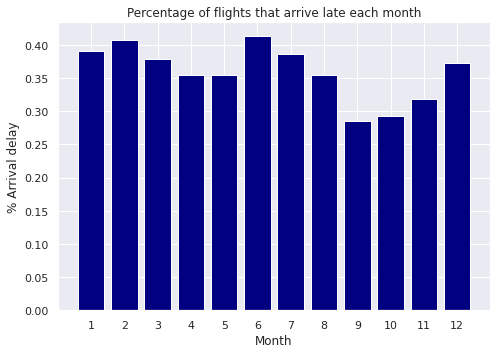

In [39]:
perc_arrival_delay_month_pandas = perc_arrival_delay_month.toPandas()
months = perc_arrival_delay_month_pandas.MONTH
perc = perc_arrival_delay_month_pandas.PERC_ARRIVAL_DELAY

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xticks(range(1,13,1))
ax.set_ylabel('% Arrival delay')
ax.set_xlabel('Month')
ax.set_title('Percentage of flights that arrive late each month')
ax.bar(months,perc, color='#000080')
plt.show()

**b. Percentage of flights that arrive late each day of week.**

First we select the dataframe that will be displayed, to do that group the dat by `DAY_OF_WEEK`, the sum all the values of the column `binaryArrDelay` and divide them by the count of `binaryArrDelay` 

In [40]:
perc_arrival_delay_dayofweek = flightsDf.groupBy("DAY_OF_WEEK").agg(round(sum("binaryArrDelay")/count("binaryArrDelay"), 4)\
                                                          .alias("PERC_ARRIVAL_DELAY")).orderBy('DAY_OF_WEEK', ascending=True)
perc_arrival_delay_dayofweek.show()

+-----------+------------------+
|DAY_OF_WEEK|PERC_ARRIVAL_DELAY|
+-----------+------------------+
|          1|            0.3636|
|          2|            0.3501|
|          3|            0.3567|
|          4|            0.3859|
|          5|             0.378|
|          6|            0.3202|
|          7|            0.3508|
+-----------+------------------+



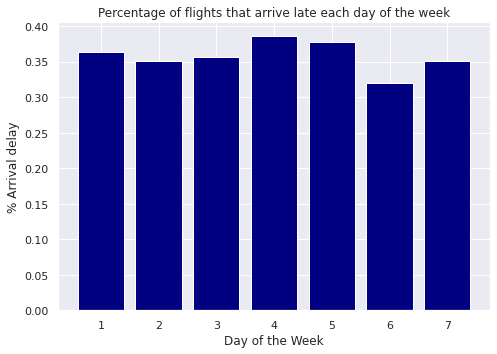

In [41]:
perc_arrival_delay_dayofweek_pandas = perc_arrival_delay_dayofweek.toPandas()
dayOfWeek = perc_arrival_delay_dayofweek_pandas.DAY_OF_WEEK
perc = perc_arrival_delay_dayofweek_pandas.PERC_ARRIVAL_DELAY

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('% Arrival delay')
ax.set_xlabel('Day of the Week')
ax.set_title('Percentage of flights that arrive late each day of the week')
ax.bar(dayOfWeek,perc, color='#000080')
plt.show()

**c. Percentage of delayed flights by airline.**

First we select the dataframe that will be displayed, to do that group the dat by `AIRLINE`, the sum all the values of the column `binaryArrDelay` and divide them by the count of `binaryArrDelay` 

In [42]:
perc_arrival_delay_airline = flightsDf.groupBy("AIRLINE").agg(round(sum("binaryArrDelay")/count("binaryArrDelay"), 4)\
                                                          .alias("PERC_ARRIVAL_DELAY")).orderBy('AIRLINE', ascending=True)
perc_arrival_delay_airline.show()

+-------+------------------+
|AIRLINE|PERC_ARRIVAL_DELAY|
+-------+------------------+
|     AA|            0.3492|
|     AS|            0.3324|
|     B6|             0.384|
|     DL|            0.2846|
|     EV|            0.3773|
|     F9|            0.4529|
|     HA|            0.4025|
|     MQ|            0.3526|
|     NK|            0.4868|
|     OO|            0.3781|
|     UA|            0.3621|
|     US|            0.3834|
|     VX|            0.4001|
|     WN|            0.3711|
+-------+------------------+



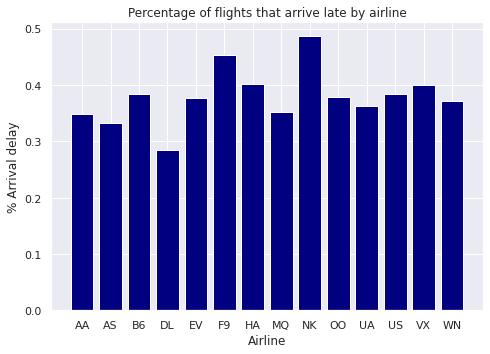

In [43]:
perc_arrival_delay_airline_pandas = perc_arrival_delay_airline.toPandas()
airline = perc_arrival_delay_airline_pandas.AIRLINE
perc = perc_arrival_delay_airline_pandas.PERC_ARRIVAL_DELAY

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('% Arrival delay')
ax.set_xlabel('Airline')
ax.set_title('Percentage of flights that arrive late by airline')
ax.bar(airline,perc, color='#000080')
plt.show()

## 2. Feature extraction and ML Training <a class="anchor" id="2"></a>

In [14]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

### 2.1 Feature selection <a class="anchor" id="2.1"></a>
[Back to top](#table)

In this feature selection, we are able to choose any column, and we are aware that every column could give us information for the prediction. Even though there are two things we want to remove from our dataset. The first one if the NA values, we have that many rows that we can drop the rows that have at least one missing value and we still have many rows to do the analysis. The NA values are problematic, and we can't calculate the correlation matrix, with this type of values. 

In previous taks we removed the columns that have a rate of missing values over than 50%, but we did not remove the missing values from the remaining one. 

In [15]:
flightsDf = flightsDf.na.drop()

The second thing we want to remove are the columns that only have one distinct value, these columns does not bring any benefit to the analysis, the can't be used in our correlation matrix either. Therefor they are going to be removed

In [16]:
# Dataset that stores the number of unique values per column
uniqueValueCounts = flightsDf.agg(*(countDistinct(col(x)).alias(x) for x in flightsDf.columns))

# List of columns that only have 1 unique value
oneUniqueValueCols = [x for x in uniqueValueCounts.columns if uniqueValueCounts.collect()[0][x] == 1]
oneUniqueValueCols

['YEAR', 'DIVERTED', 'CANCELLED']

Now we can see that the columns `YEAR`, `DIVERTED`, and `CANCELLED` only have one unique value, that why they are useless and are going to be dropped

In [17]:
# List wth columns that have more than one different value
cols = [x for x in uniqueValueCounts.columns if uniqueValueCounts.collect()[0][x] > 1]

# Removing the useless columns
flightsDf = flightsDf[cols]

After removing the NA values and the useless columns. The structure of the new dataset is

In [48]:
# Print number of partitions, rows and columns
print("The dataframe flightsDf has", flightsDf.count(),'rows and', len(flightsDf.columns), "columns")

The dataframe flightsDf has 571729 rows and 28 columns


When we remove the columns over the threshold we had 25 columns, then we added 6 columns more for classification, and now we are removing 3. Having a total of 28 columns. 
Also we had 582,184 rows and by removing the NA values we dropped 10,455. That could sound like to many rows, but it is only the 1.79% of the entire dataframe 

**a. Correlation Matrix**                              
Now we are going to calculate the correlation matrix for the dataset, but we are dropping the categorical ones, as they have no correlation with any other. Also removing the labels created above, as we are only finding correlation between attributes.

When using the `Pearson` correlation between variables, we must drop the categorical columns becaudse there is no such a thing like correlation between categorical values between them of with a numerical one. When plotting the correlation matrix if we use categorical values, all the row or column where the categorical value is displayed shows no value, therefore, it can not be analyzed. In this case as we are using the following categorical features: `AIRLINE`, `TAIL_NUMBER`, `ORIGIN_AIRPORT`, `DESTINATION_AIRPORT`, which are features that we consider meaningful for training the model. That is why we are going to use those features, regardless the correlation between other variables.

In [49]:
inputColumns = [f.name for f in flightsDf.schema.fields if not isinstance(f.dataType, StringType)] # Removing strings 
inputColumns = [c for c in inputColumns if c not in label_cols] # Removing labels

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=inputColumns, outputCol=vector_col)
flightsDf_vector = assembler.transform(flightsDf).select(vector_col)
matrix = Correlation.corr(flightsDf_vector, vector_col, "pearson").collect()[0][0]
corrmatrix = matrix.toArray().tolist()

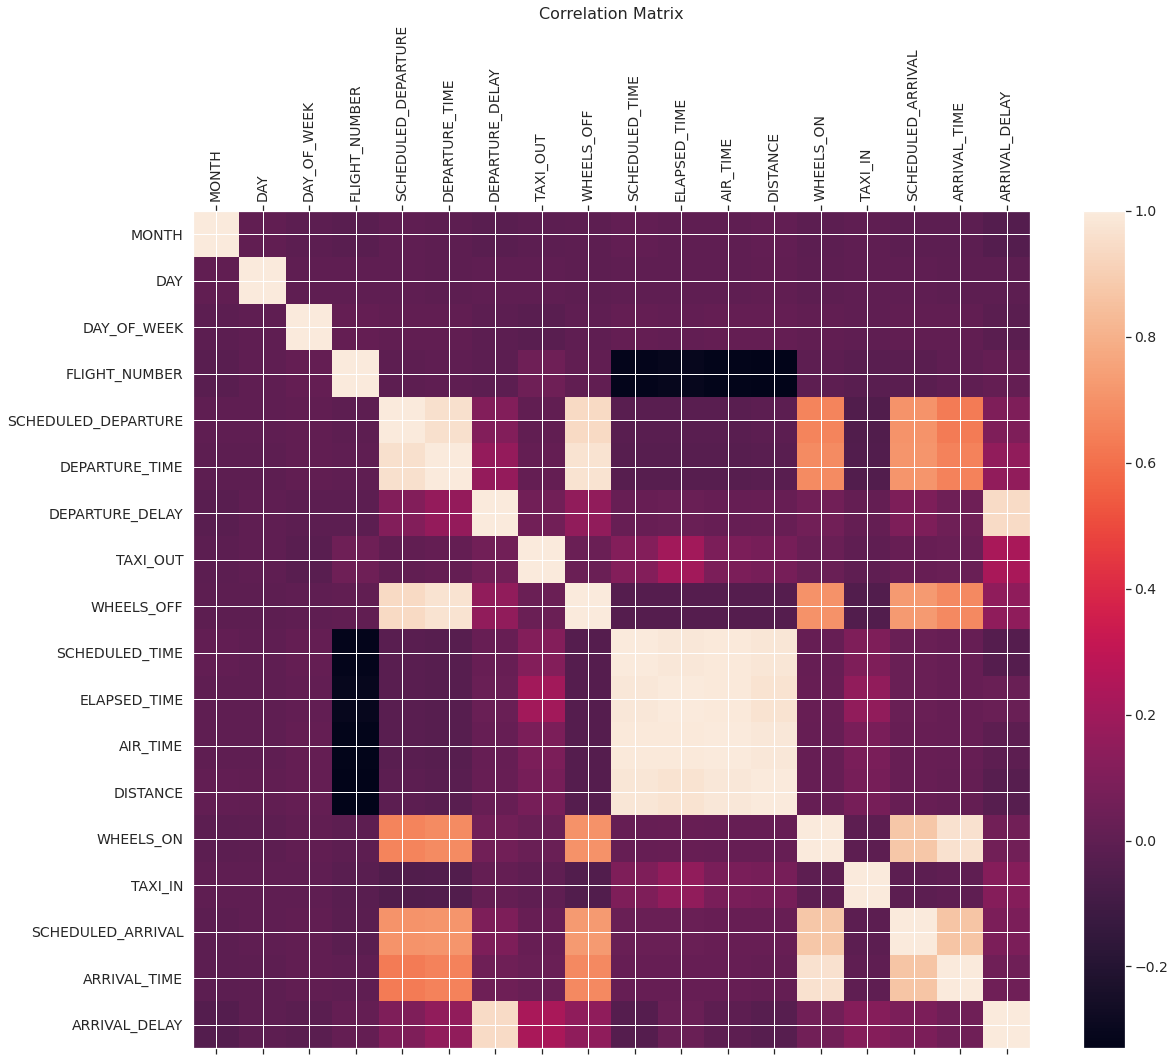

In [50]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corrmatrix, fignum=1)
plt.xticks(range(len(inputColumns)), inputColumns, fontsize=14, rotation=90)
plt.yticks(range(len(inputColumns)), inputColumns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

After analyzing the correlation matrix, we concluded the following things:
* We must remove `DEPARTURE_DELAY` and `ARRIVAL_DELAY`. These two features helped us construct the labels, so inderectly those are the labels of the model, so we have to remove them as this is what we want to predict.
* To avoid multicolinearity problems, we must remove highly highly correlated variables. In this case we can see that `FLIGHT_NUMBER` is highly correlated with 4 variables, and `WHEELS_OFF`  does too with 2 of them.
* Following the multicolinearity problems we can see that in the middle of the matrix, there are 4 variables that are highly positive correlated, those are `SCHEDULED_TIME`, `ELAPSED_TIME`, `AIR_TIME`, and `DISTANCE`. If we think it closely those variables are almost the same, and all of them depend of each other. That is why if we only keep one. The other would be represented. That is why we are only going to select `DISTANCE` that could better represent the other ones.

**Summary:** In order to avoid the curse of the dimensionality we are going to select the less number of features that better represent the dataset, in order to make the best prediction possible. In this case as it was already mentioned we are going to remove the following columns.

* DEPARTURE_DELAY
* ARRIVAL_DELAY
* FLIGHT_NUMBER
* WHEELS_OFF
* SCHEDULED_TIME
* ELAPSED_TIME
* AIR_TIME

In [18]:
removed_features = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'FLIGHT_NUMBER',\
                    'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME']
feature_selection = [c for c in flightsDf.columns if c not in removed_features]
flightsDf = flightsDf[feature_selection]
flightsDf.columns

['MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'TAXI_OUT',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'binaryArrDelay',
 'binaryDeptDelay',
 'multiClassArrDelay',
 'multiClassDeptDelay',
 'multiClassArrDelayAuto',
 'multiClassDeptDelayAuto']

After the feature selection the columns above are the columns that we will use to train our models, and now we will categorize these columns again into `numerical` and `categorical`

In [19]:
cat_columns = [f.name for f in flightsDf.schema.fields if isinstance(f.dataType, StringType)]
num_columns = list(set([f.name for f in flightsDf.schema.fields if not isinstance(f.dataType, StringType)])-set(label_cols))
label_cols = label_cols # It was created before

### 2.2 Preparing Spark ML Transformers/ Estimators <a class="anchor" id="2.2"></a>
[Back to top](#table)

Before we perform the training of the model, we proceed to transform the dataset, as we considered that the categorical values are important. We need to convert them from string to numeric with `StringIndexer`, after that we need to convert those columns into One Hot Value using the function `OneHotEncoder`, and after that we assambled all the columns together (Categorical converted to OneHot and the numerical one)

In [20]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

#### 2.2.1 Transform the dataset <a class="anchor" id="2.2.1"></a>
**a. Feature Engineering**                       
Each stage of the transformation is showed here

First we add a new column to the dataframe 

In [21]:
indexer = StringIndexer(inputCols = cat_columns, outputCols = [f'{x}_index' for x in cat_columns])
encoder = OneHotEncoder(inputCols = [f'{x}_index' for x in cat_columns], outputCols = [f'{x}_vec' for x in cat_columns])
assembler = VectorAssembler(inputCols = (num_columns + [f'{x}_vec' for x in cat_columns]), outputCol = 'features')

**b. Pipeline**                      
Having all the satges of the transformation, we proceed to use the function `Pipeline` to perform all the stages at once, and getting as the output a new dataframe called `flightsDf_transformed` that has all the original features, and the ones created by us. From this dataset we can select manually the columns that we want to use in each estimator

In [22]:
pipeline = Pipeline(stages = [indexer,encoder,assembler])
pipelineModel = pipeline.fit(flightsDf)
flightsDf_transformed = pipelineModel.transform(flightsDf)

#### 2.2.2 Model Estimators <a class="anchor" id="2.2.2"></a>
**a. Decision Tree**                                               
To build the Decision Tree model we are going to use `binaryArrDelay` and `binaryDeptDelay` as labels. That is why we will create two different estimators with `maxDepth = 3`

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier

# Build Decision Tree Classifier with the corresponding label and maxDepth = 3
dt_ArrDelay = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'binaryArrDelay', maxDepth = 3)
dt_DeptDelay = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'binaryDeptDelay', maxDepth = 3)

**b. Gradient Boosted Tree**                                               
As we did before, to build the Gradient Boosted Tree we are going to use `binaryArrDelay` and `binaryDeptDelay` as labels. That is why we will create two different estimators with `maxDepth = 3`

In [24]:
from pyspark.ml.classification import GBTClassifier

# Build Gradient Boosted Tree Classifier with the corresponding label and maxIter = 10
gbt_ArrDelay = GBTClassifier(featuresCol = 'features', labelCol = 'binaryArrDelay', maxIter = 3)
gbt_DeptDelay = GBTClassifier(featuresCol = 'features', labelCol = 'binaryDeptDelay', maxIter = 3)

**c. Naive Bayes**                                               
In this case, to build the Naive Bayes estimator we are going to use `multiClassArrDelayAuto` and `multiClassDeptDelayAuto` as labels, that are the labels that we created automaticlly in the task 1.3.3. That is why we will create two different estimators with `smoothing = 1` and `modelType=multinomial`

In [25]:
from pyspark.ml.classification import NaiveBayes

# Build Naive Bayes Classifier with the corresponding label and maxIter = 10
nb_ArrDelay = NaiveBayes(featuresCol = 'features', labelCol ='multiClassArrDelayAuto', modelType='multinomial')
nb_DeptDelay = NaiveBayes(featuresCol = 'features', labelCol ='multiClassDeptDelayAuto', modelType='multinomial')

### 2.3 Split dataset <a class="anchor" id="2.3"></a>
[Back to top](#table)

In this task we randomly split the data into 80% and 20% proportion as training and testing data. We are going to use a seed in order to replicate the result. This training and testing data will be used for model evaluation

In [26]:
#Splitting the data into testing and training set 80% into training and 20% for testing
train, test = flightsDf_transformed.randomSplit([0.8, 0.2], 23) # Using 123 as a seed to always get the same dataset 

### 2.4 Training and evaluating models <a class="anchor" id="2.4"></a>
[Back to top](#table)

#### 2.4.1 Binary Classification <a class="anchor" id="2.4.1"></a>
First we perform the binary classification task, using Decision Tree and Gradient Boosted Tree models, for both arrival and departure delay classification. Which means 4 different models.

**a. Decision Tree**                                          
With the estimators created in the previous task, we proceed to train both models, one for `ARRIVAL_DELAY` and one for `DEPARTURE_DELAY`

In [27]:
dt_ArrDelay_Model = dt_ArrDelay.fit(train)

In [28]:
dt_DeptDelay_Model = dt_DeptDelay.fit(train)

After the models are trained we will predict the values 

In [29]:
dt_ArrDelay_Predictions = dt_ArrDelay_Model.transform(test)

In [30]:
dt_DeptDelay_Predictions = dt_DeptDelay_Model.transform(test)

Now that we have the predictions, we can calculate the confusion matrix

In [31]:
# show confusion matrix
dt_ArrDelay_Predictions.groupBy('binaryArrDelay', 'prediction').count().show()

+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|31343|
|             0|       0.0|69345|
|             1|       1.0|10459|
|             0|       1.0| 3705|
+--------------+----------+-----+



In [32]:
# show confusion matrix
dt_DeptDelay_Predictions.groupBy('binaryDeptDelay', 'prediction').count().show()

+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|31716|
|              0|       0.0|64738|
|              1|       1.0|10735|
|              0|       1.0| 7663|
+---------------+----------+-----+



Finally, we will canculate the metrics that will help us evaluate the performance of each model

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Library use to calculate AUC

def compute_metrics(predictions, label):
    new_label_name = str(label + " as label")
    predictions = predictions.selectExpr("prediction as prediction", new_label_name)
    
    # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()

    # calculate metrics by the confusion matrix
    accuracy = (TP + TN)/(TP + TN + FN + FP)
    precision = (TP)/(TP + FP)
    recall = (TP)/(TP + FN)
    auc = BinaryClassificationEvaluator(rawPredictionCol="prediction").evaluate(predictions)
    
    return print("Accuracy: ", accuracy, "\nPrecision: ", precision, "\nRecall: ", recall, "\nAUC: ", auc)

In [34]:
compute_metrics(dt_ArrDelay_Predictions, 'binaryArrDelay')

Accuracy:  0.6948420576045694 
Precision:  0.7384213499011578 
Recall:  0.25020333955313145 
AUC:  0.5997423268607546


In [35]:
compute_metrics(dt_DeptDelay_Predictions, 'binaryDeptDelay')

Accuracy:  0.6571326576811897 
Precision:  0.5834873355799544 
Recall:  0.2528797908176486 
AUC:  0.5735193556372742


When looking at the metrics of the `Decision Tree Model` for each label we can observe that the performance is similar for both models, even though the performance of the `ARRIVAL` label is slightly better. In this case we can see that the biggest flaw of the models is the **Recall**, which means that it has some troubles with *false negatives*, it predicts some late flights as not late. This can be seen with recalls below 30%. 

As mentioned before, when comparing the `ARRIVAL`, and the `DEPARTURE` models we can see that for the model with the parameters and features selected, can predict easier is a flight is going to `DEPART` late, rather than knowing if the flight is going to `ARRIVE` late, there are some unseen things while the airplane is flying that the models can not percept.

**b. Gradient Boost Tree**                                          
As we did with `Decision Tree Model`, we do the same with the `Gradient Boost Tree` with the estimators created in the previous task, we proceed to train both models, one for `ARRIVAL_DELAY` and one for `DEPARTURE_DELAY`

In [36]:
gbt_ArrDelay_Model = gbt_ArrDelay.fit(train)

In [37]:
gbt_DeptDelay_Model = gbt_DeptDelay.fit(train)

After the models are trained we will predict the values 

In [38]:
gbt_ArrDelay_Predictions = gbt_ArrDelay_Model.transform(test)

In [39]:
gbt_DeptDelay_Predictions = gbt_DeptDelay_Model.transform(test)

Now that we have the predictions, we can calculate the confusion matrix

In [40]:
# show confusion matrix
gbt_ArrDelay_Predictions.groupBy('binaryArrDelay', 'prediction').count().show()

+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|28356|
|             0|       0.0|68451|
|             1|       1.0|13446|
|             0|       1.0| 4599|
+--------------+----------+-----+



In [41]:
# show confusion matrix
gbt_DeptDelay_Predictions.groupBy('binaryDeptDelay', 'prediction').count().show()

+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|27572|
|              0|       0.0|64631|
|              1|       1.0|14879|
|              0|       1.0| 7770|
+---------------+----------+-----+



Finally, we will canculate the metrics that will help us evaluate the performance of each model

In [42]:
compute_metrics(gbt_ArrDelay_Predictions, 'binaryArrDelay')

Accuracy:  0.7130655103959879 
Precision:  0.7451371571072319 
Recall:  0.32165925075355245 
AUC:  0.6293511859517249


In [43]:
compute_metrics(gbt_DeptDelay_Predictions, 'binaryDeptDelay')

Accuracy:  0.6922822414934002 
Precision:  0.6569384961808469 
Recall:  0.35049822147888154 
AUC:  0.6215896308980021


### Discussion

When looking at the metrics of the `Gradient Boosting Tree Model` for each label we can observe that the performance is similar for both models, as we identified for the last model, the performance of the `ARRIVAL` label is slightly better and the biggest flaw of the models is the **Recall**, which means that it has some troubles with *false negatives*, it predicts some late flights as not late. This can be seen with recalls below 40%. 

When comparing the `Decision Tree Model` and the `Gradient Boosting Model` we can observe that the performance of the second is way better than the first one, all the metrics of the `Gradient Boosting Model` are better than the metrics of the `Decision Tree Model`, it means that one captures better the behaviour of the DELAYS than the other one.

**Model Selection for Binary Class**

If we had to select one model to predict whether a flight is going to be delay or not, I would choose the `Gradient Boosting Tree Model`, using this one I can guarantee more accurate results, and I would have less false negatives, which are the most undesirable prediction. In terms of metrics, the one that will help use understand better the performance of the model is the `Area Under the Curve ROC` because it will help us undertand the degree of separability between the labels, and how well the model can capture it. The other metrics like, accuracy, recall and precision are also good to measure the performance of the model, even though in this case, as the data seems a little bit unbalanced as we could see in the [graphs above](#1.3.1), some of the metrics could be biased, like in this case `Precision` and `Recall`. 

That is why in this case, we will stick to the AUC ROC metric, that will help us distingush the separability between labels.

**Improvement of the Model**

If we wanted to improve the performance of each model, we would have many options that we could use, those options are listed below:
1. **Stepwise feature selection:** Using `Backward stepwise` or `Forward stepwise feature selection`, we could easily understand which are the most important features for the prediction of the label. In this particular case, we did not do that and just got rid of features that had a high correlation between them, in order to avoid multicollinearity issues. Using this method we did not test which were the most important features, so we could have gotten rid of the most important features for predicting the label, without knowing it. If we really wanted to select the best features for the models, we would need to use `Stepwise selection`, this way we could understand which are the attributes that have a greater impact on the performance of the model, and this way just got rid of the unimportant ones.
2. **Cross-Validation:** Using the `Cross-Validation method`, we could calculate better the performance of the model and its consistency. In this particular case, we just split the data once, therefore, we could not understand how consistent is the prediction, and how accurate are the metrics. Because we can only have one result rather than many of them. Using `Cross-Validation` as the split method we could understand better the output of the model.
3. **Hyperparameter tunning:** Using `Hyperparameter tunning` we could have tested many different parameters in the model. In this case, we only analyzed one hyperparameter for each model: **MaxDepth** for Decision Tree and **MaxIter** for Gradient Boosting Tree, and we don't really know if these hyperparameters are the ones that retrieve the best outcome possible, that is why are we compared the performance of each model, with different hyperparameters we would be able to understand which is the best hyperparameter and then used it in the final model.

If we had used all these methods together, we would be sure that we are selecting the best model possible, but taking into consideration that we are using more than 500.000 rows, using these methods of hypertunning would be really expensive to achieve, and we do not have the resources to achieve it. That is why even though we are aware that this is not the most accurate approach, we know that it is a really good one.

#### 2.4.2 Multiclass Classification <a class="anchor" id="2.4.2"></a>

**a. Naive Bayes**                                        
Finally, as we did with in binary classification models, we proceed to do the same with the `Naive Bayes Model` with the estimators created in the previous task, we proceed to train both models, one for `ARRIVAL_DELAY` and one for `DEPARTURE_DELAY`

In [44]:
nb_ArrDelay_Model = nb_ArrDelay.fit(train)

In [45]:
nb_DeptDelay_Model = nb_DeptDelay.fit(train)

After the models are trained we will predict the values 

In [46]:
nb_ArrDelay_Predictions = nb_ArrDelay_Model.transform(test)

In [47]:
nb_DeptDelay_Predictions = nb_DeptDelay_Model.transform(test)

Now that we have the predictions, we can calculate the confusion matrix

In [48]:
# show confusion matrix
nb_ArrDelay_Predictions.groupBy('multiClassArrDelayAuto', 'prediction').count().show()

+----------------------+----------+-----+
|multiClassArrDelayAuto|prediction|count|
+----------------------+----------+-----+
|                     2|       1.0|10979|
|                     1|       0.0|10223|
|                     0|       2.0|11132|
|                     0|       0.0|24899|
|                     1|       2.0| 6354|
|                     2|       2.0| 9781|
|                     1|       1.0|10951|
|                     2|       0.0|11217|
|                     0|       1.0|19316|
+----------------------+----------+-----+



In [49]:
# show confusion matrix
nb_DeptDelay_Predictions.groupBy('multiClassDeptDelayAuto', 'prediction').count().show()

+-----------------------+----------+-----+
|multiClassDeptDelayAuto|prediction|count|
+-----------------------+----------+-----+
|                      2|       1.0|11275|
|                      1|       0.0|19898|
|                      0|       2.0| 4042|
|                      0|       0.0| 9944|
|                      1|       2.0|14411|
|                      2|       2.0|11376|
|                      1|       1.0|26805|
|                      2|       0.0| 8483|
|                      0|       1.0| 8618|
+-----------------------+----------+-----+



**Departure Delay Multiclass**

In [50]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

predictions = nb_DeptDelay_Predictions.selectExpr("prediction as prediction", "multiClassDeptDelayAuto as label")

y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
y_test = predictions.select("label").rdd.flatMap(lambda x: x).collect()

print('Classification Report\n')
print(classification_report(y_test, y_pred, target_names=['0', '1', '2']))
print("AUC:", BinaryClassificationEvaluator(rawPredictionCol="prediction").evaluate(predictions))

Classification Report

              precision    recall  f1-score   support

           0       0.26      0.44      0.33     22604
           1       0.57      0.44      0.50     61114
           2       0.38      0.37      0.37     31134

    accuracy                           0.42    114852
   macro avg       0.40      0.41      0.40    114852
weighted avg       0.46      0.42      0.43    114852

AUC: 0.5825118259495178


**Arrival Delay Multiclass**

In [51]:
predictions = nb_ArrDelay_Predictions.selectExpr("prediction as prediction", "multiClassArrDelayAuto as label")

y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
y_test = predictions.select("label").rdd.flatMap(lambda x: x).collect()

print('Classification Report\n')
print(classification_report(y_test, y_pred, target_names=['0', '1', '2']))
print("AUC:", BinaryClassificationEvaluator(rawPredictionCol="prediction").evaluate(predictions))

Classification Report

              precision    recall  f1-score   support

           0       0.54      0.45      0.49     55347
           1       0.27      0.40      0.32     27528
           2       0.36      0.31      0.33     31977

    accuracy                           0.40    114852
   macro avg       0.39      0.38      0.38    114852
weighted avg       0.42      0.40      0.40    114852

AUC: 0.5550360808698187


### Discussion
**Metrics**                                             
In this case we belive that the AUC is not the best metric to calculate the performance of the `Naive-Bayes Model` because it is using the `BinaryClassificationEvaluator` while we are using three different classes. It could lead us to a misunderstanding of the model perfomance. In this case we are going to calculate the performace of the models just by using the `Accuracy`, `Precision` and `Recall`. From the metrics we can see that the performance of it is not that good, as the accuracy is just ~40%, and there is not metric above 50%, which clearly means that we are not even able to predict it slightly better than by chance. It is claer that we must improve everything is this models if really wanted to use it.

**Improvement of the Model**                                                                     
If we wanted to improve the performance of the multiclass model, we would have many options that we could use, those options are listed below:
1. **Stepwise feature selection:** Using `Backward stepwise` or `Forward stepwise feature selection`, we could easily understand which are the most important features for the prediction of the label. In this particular case, we did not do that and just got rid of features that had a high correlation between them, in order to avoid multicollinearity issues. Using this method we did not test which were the most important features, so we could have gotten rid of the most important features for predicting the label, without knowing it. If we really wanted to select the best features for the models, we would need to use `Stepwise selection`, this way we could understand which are the attributes that have a greater impact on the performance of the model, and this way just got rid of the unimportant ones.
2. **Cross-Validation:** Using the `Cross-Validation method`, we could calculate better the performance of the model and its consistency. In this particular case, we just split the data once, therefore, we could not understand how consistent is the prediction, and how accurate are the metrics. Because we can only have one result rather than many of them. Using `Cross-Validation` as the split method we could understand better the output of the model.
3. **Hyperparameter tunning:** Using `Hyperparameter tunning` we could have tested many different parameters in the model. In this case, we only analyzed one hyperparameter for each model: **MaxDepth** for Decision Tree and **MaxIter** for Gradient Boosting Tree, and we don't really know if these hyperparameters are the ones that retrieve the best outcome possible, that is why are we compared the performance of each model, with different hyperparameters we would be able to understand which is the best hyperparameter and then used it in the final model.
4. **Label creation:** For this particular model, we manually created the labels, in this case we defined that less than -5 minutes means early and more than +5 minutes mean late, the only argument to define that is that each category had roughly the same amount of flights, this is not a good practice, because in real life most of the flight must arrive of depart on time, so we must expect the labels to be heavily unbalanced. It would be correct if we had use many different distribution of labels, or even had read some documentation from the source of the data, of how to classify correctly the data. For sure the results are heavily influenced for the creation of this labels

If we had used all these methods together, we would be sure that we are selecting the best model possible, but taking into consideration that we are using more than 500.000 rows, using these methods of hypertunning would be really expensive to achieve, and we do not have the resources to achieve it. That is why even though we are aware that this is not the most accurate approach, we know that it is a really good one.


# References
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.corr.html                                   
https://stackoverflow.com/questions/55546467/how-to-plot-correlation-heatmap-when-using-pysparkdatabricks                    
https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas                                          
https://stackoverflow.com/questions/40888946/spark-dataframe-count-distinct-values-of-every-column         
https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826                    
https://www.baeldung.com/cs/naive-bayes-classification-performance